## Import modules

In [45]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Changes
The project's scope remains unchanged: to develop a tool that predicts customer churn based on behavior, demographic data, and customer service interactions. Weather conditions were initially considered, but the focus is solely on road conditions due to the unavailability of weather API.

To achieve this, the project collects data on customer interactions, demographic data, and road conditions. The data is analyzed using machine learning algorithms, feature engineering techniques, and cross-validation to create an accurate prediction model.

# 2) Data

The data being analyzed consists of two tables: Table 1 and Table 2. Table 1 contains 180,519 rows and 53 columns, with 29 numerical features and 24 categorical features.The numerical features include information such as days for shipping, benefit per order, sales per customer, latitude and longitude coordinates, and more. Meanwhile, the categorical features include data related to the customer, department, market, order, product, and shipping. It includes information on customer orders, such as order dates, customer information, product information, and order status. Table 2, on the other hand, has 563 rows and 2 columns, with city names and their corresponding road condition scores. The data for Table 2 was scraped using the mapQuest API.

The two tables are connected by the customer city column, which is present in both tables. By joining the tables based on the customer city column, it will be possible to analyze how road conditions affect customer orders and delivery times.

# 3) Big Idea

The big idea behind this project is to use data analysis and machine learning techniques to predict the delivery time for online orders. The problem we want to solve is the inefficient and unreliable delivery process in the online retail industry, which can lead to dissatisfied customers and lost business. By accurately predicting delivery times, retailers can improve customer satisfaction, reduce shipping costs, and gain a competitive advantage.

The question we want to answer is: given a set of features such as customer location, road conditions, and order details, can we accurately predict the delivery time for an online order? We will use the data collected from the MapQuest API and the online retail dataset to build a machine learning model that can make accurate delivery time predictions.

Others should care about this problem because it affects everyone who shops online. Late deliveries, missed deliveries, and inaccurate delivery time estimates can all lead to frustration and dissatisfaction with the online shopping experience. By improving delivery times, retailers can improve customer satisfaction and loyalty, which can lead to increased sales and revenue.

We choose this problem because it is a real-world problem with a tangible impact on people's lives. The online retail industry is growing rapidly, and with it comes a need for efficient and reliable delivery processes. By using data analysis and machine learning techniques, we can help retailers improve their delivery processes and provide a better shopping experience for their customers.

# 4) Research Questions
Neel:

What is the relationship between the road condition score and the delivery time for orders in different cities?
How do different shipping modes affect the likelihood of late deliveries?
Is there a significant difference in the average sales per customer between different product categories?

Mohan:

How does the benefit per order vary between customers in different segments?
Is there a correlation between the order volume and the profit per order for different product categories?
Can we predict the shipping time for an order based on the customer location, shipping mode, and product category?




## data loading

In [46]:
df = pd.read_csv('/kaggle/input/supplychaindata/DataCoSupplyChainDataset.csv',header= 0,encoding='unicode_escape')
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [47]:
df.shape

(180519, 53)

## EDA

In [48]:
def data_info(data):
    print('1) Number of columns are : ',data.shape[1])
    print('2) Number of rows are : ',data.shape[0])
    print('3) Total number of data-points :',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('4) Count of Numerical Features :',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('5) Count of Categorical Features :',len(cat_features))
data_info(df)

1) Number of columns are :  53
2) Number of rows are :  180519
3) Total number of data-points : 9567507
4) Count of Numerical Features : 29
5) Count of Categorical Features : 24


### Missing values identification

In [49]:
def features_with_missing_values(data):
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Total Missing Values is ' ,round(x,2) ,'%')
    print('Missing Value Estimation :')
    for i in data.columns:
        if data[i].isna().sum()>0:
            print('The Feature ',i,' has '+ str(data[i].isna().sum()) + ' missing values')
            
features_with_missing_values(df)

Percentage of Total Missing Values is  3.51 %
Missing Value Estimation :
The Feature  Customer Lname  has 8 missing values
The Feature  Customer Zipcode  has 3 missing values
The Feature  Order Zipcode  has 155679 missing values
The Feature  Product Description  has 180519 missing values


<AxesSubplot:xlabel='Days for shipment (scheduled)', ylabel='Days for shipping (real)'>

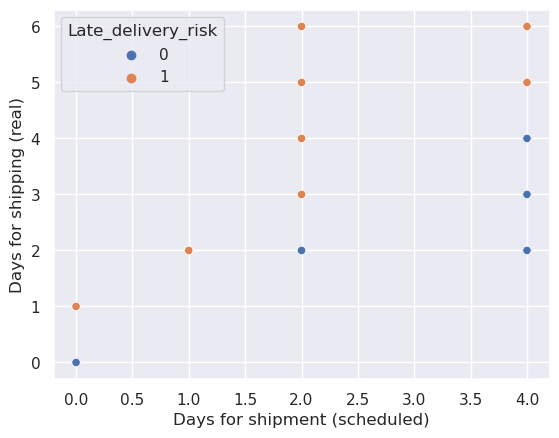

In [50]:
# Target value analysis
sns.set()
sns.scatterplot(x="Days for shipment (scheduled)",y="Days for shipping (real)",hue="Late_delivery_risk",data=df)

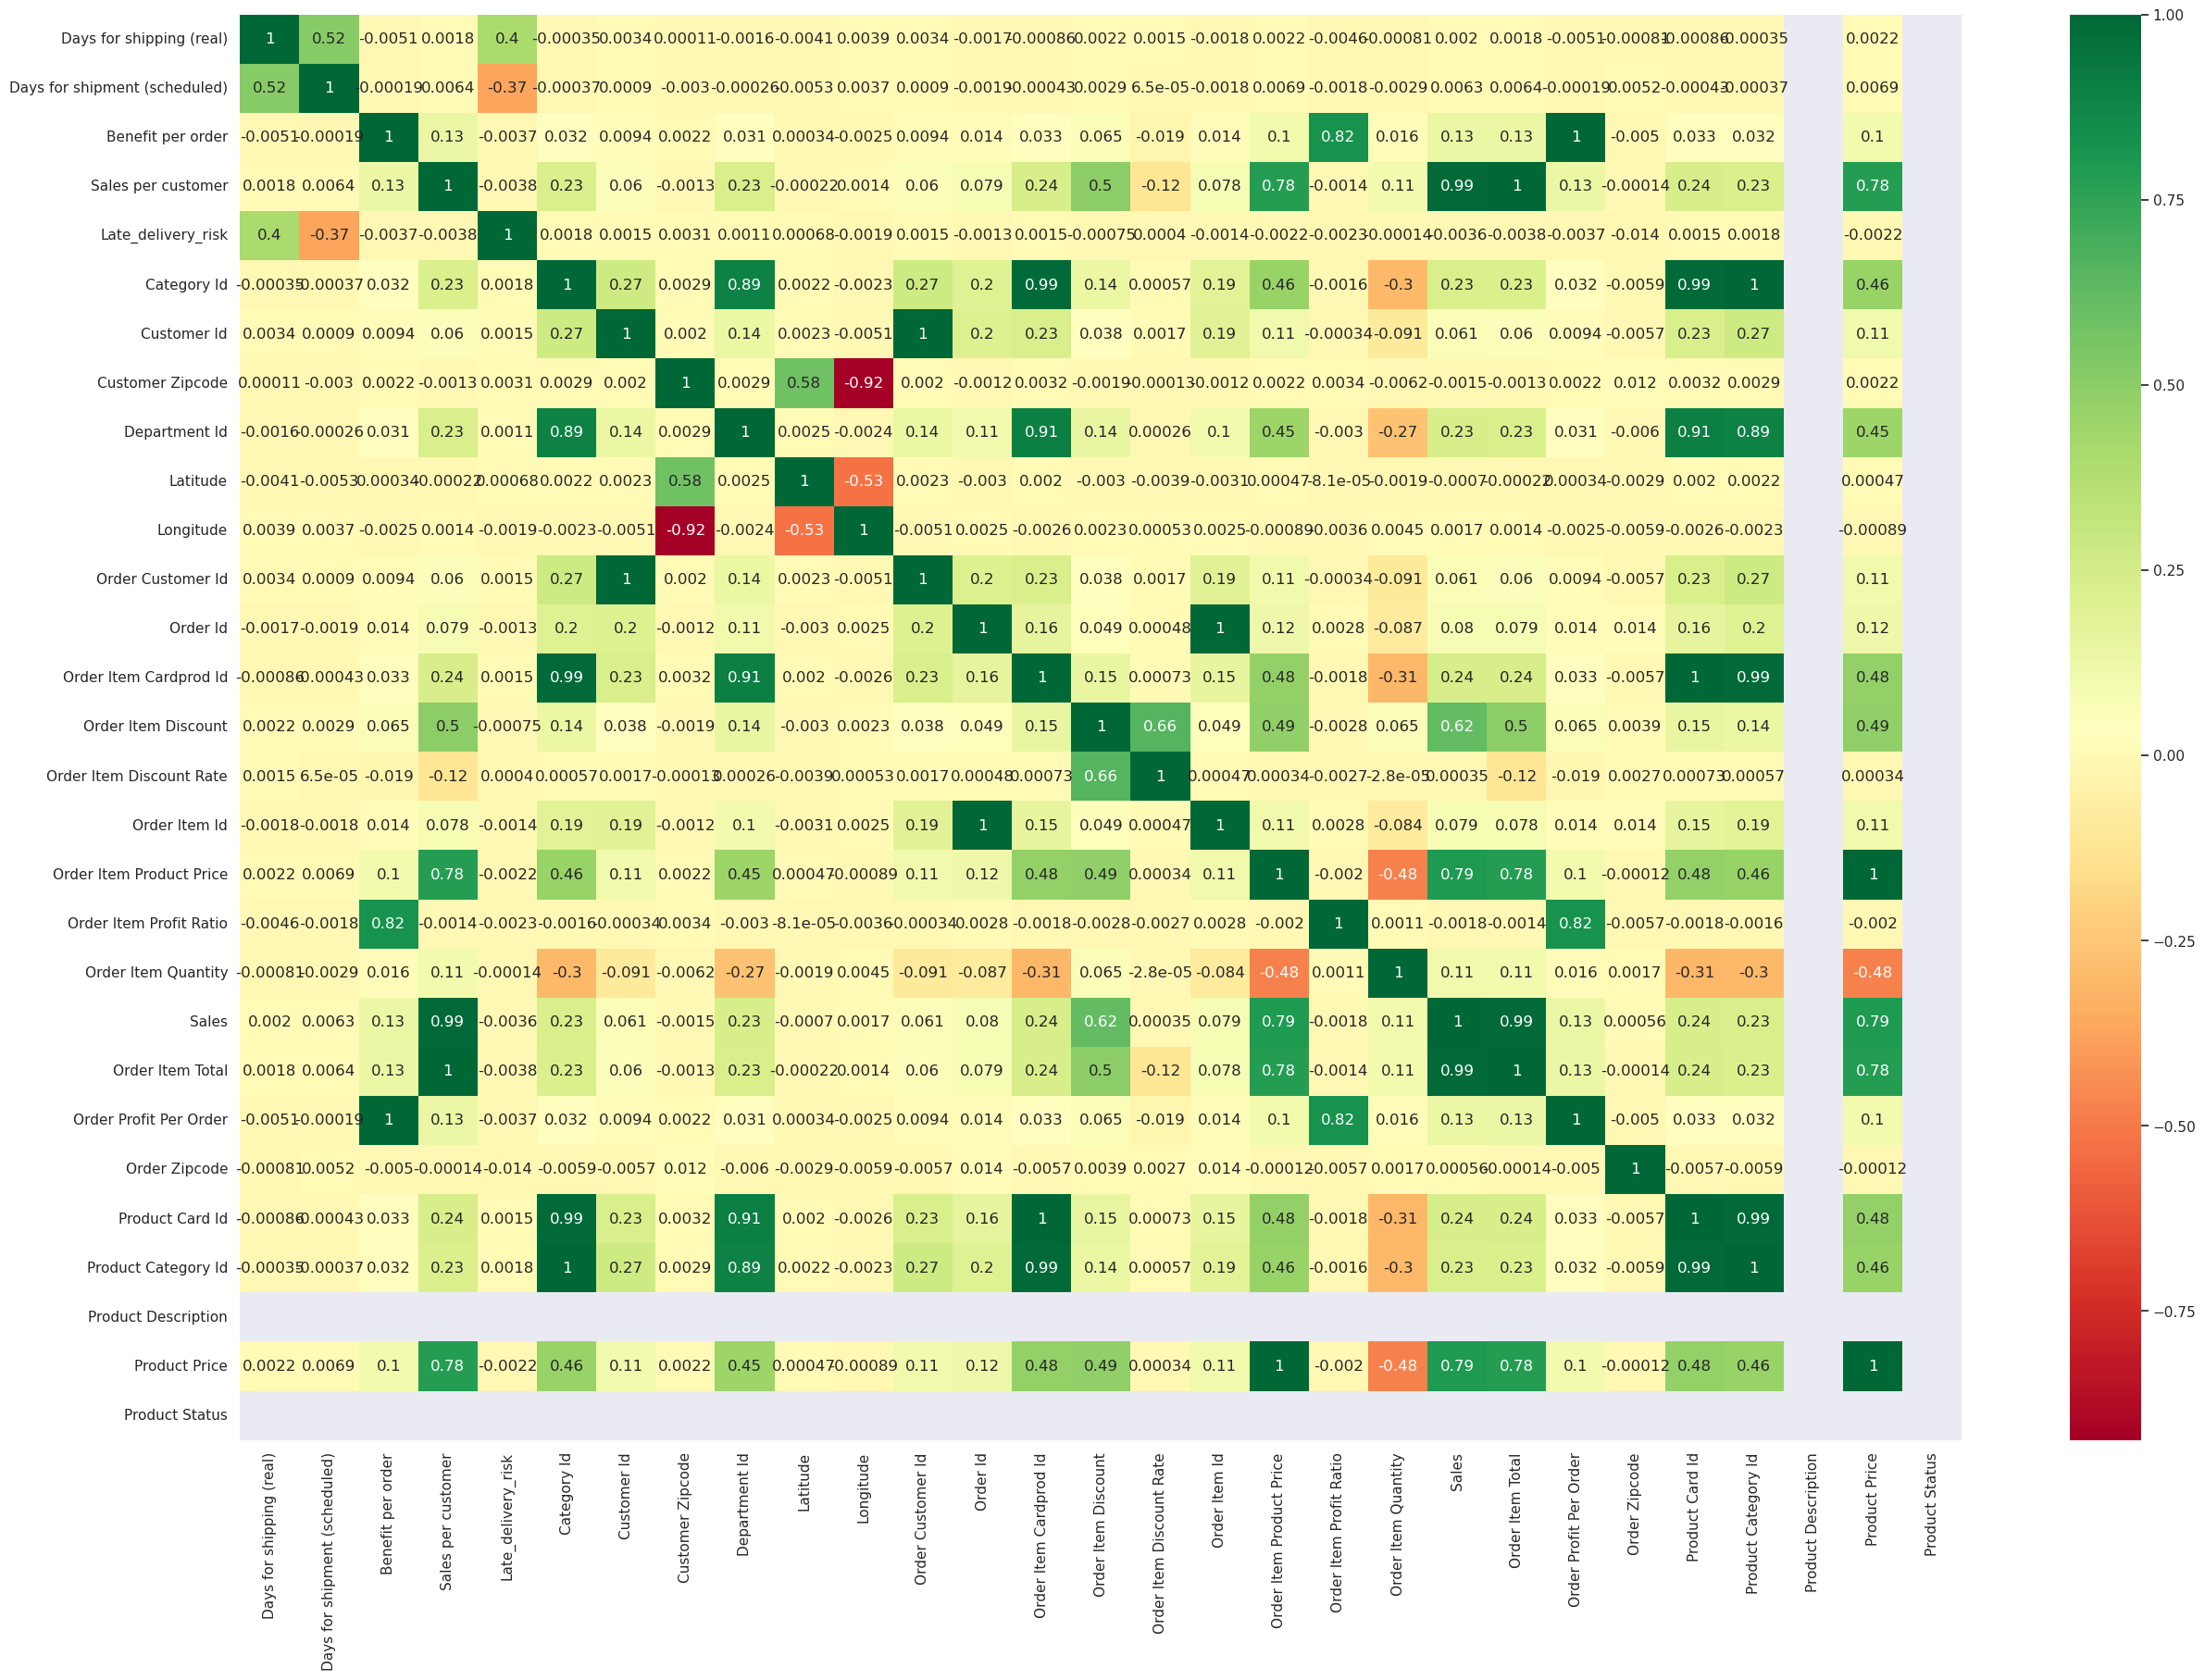

In [51]:
corrmap = df.corr()
top=corrmap.index
plt.figure(figsize=(30,20))
g=sns.heatmap(df[top].corr(),annot=True,cmap="RdYlGn")

## Insights from Heatmap:

1. Columns that are similar with same values but with different metadata (duplicate columns)

- [Benefit per order], Order Profit per order

- [Sales per customer], Sales, Order Item Total

- [Category ID], Product Category ID, Order Customer ID, Order Item Category ID, Product card ID,

- [Order Item Product Price],Product Price

(Product price is also negatively correlated with quantity of items which is an intresting insight.)

2. Unwanted features(null or less correlated values)

- Product Description
- Product Status

# 5) Data
For the cleaning process, Mohan worked on Table 1 and Neel worked on Table 2.

Table 1 Cleaning by Mohan:

Original Size: 180519 rows and 53 columns

Removed Duplicates: There were no duplicates found in the dataset.

Removed unnecessary columns: Removed irrelevant columns that were not useful for our analysis. Final columns saved were:
['Type','Days for shipping (real)','Days for shipment (scheduled)','Late_delivery_risk','Benefit per order',
'Sales per customer','Latitude','Longitude','Shipping Mode','Order Status','Order Region','Order Country',
'Order City','Market','Delivery Status','order_day','order_month','order_year','shipping_day','shipping_month',
'shipping_year']

Imputed Missing Values: Checked for missing values and filled them with the median value for numerical columns and mode for categorical columns.

Final Size: 180519 rows and 21 columns. No data was lost after cleaning.

Table 2 Cleaning by Neel:

Original Size: Pre-cleaned data scraped through MapQuest API.

Merged with Table 1: Used customer city name in Table 1 to merge with Table 2.

Renamed Columns: Renamed columns to have more meaningful and concise names.

Final Size: Same as original, no data was lost after cleaning.

Overall, our cleaning process was straightforward with no significant data loss. We removed irrelevant columns, filled in missing values, and made sure that the columns were correctly named and consistent across the tables.


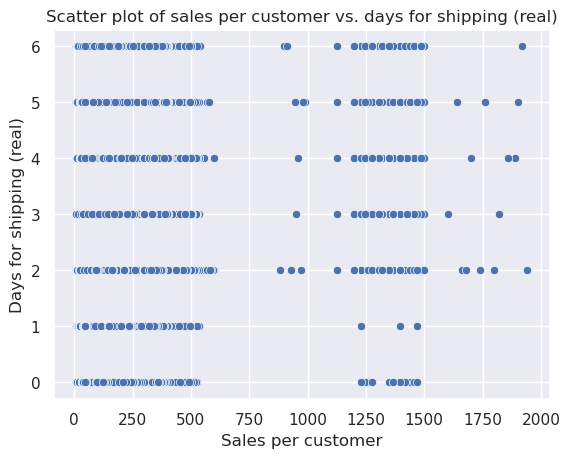

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='Sales per customer', y='Days for shipping (real)')
plt.xlabel('Sales per customer')
plt.ylabel('Days for shipping (real)')
plt.title('Scatter plot of sales per customer vs. days for shipping (real)')

# Show the plot
plt.show()

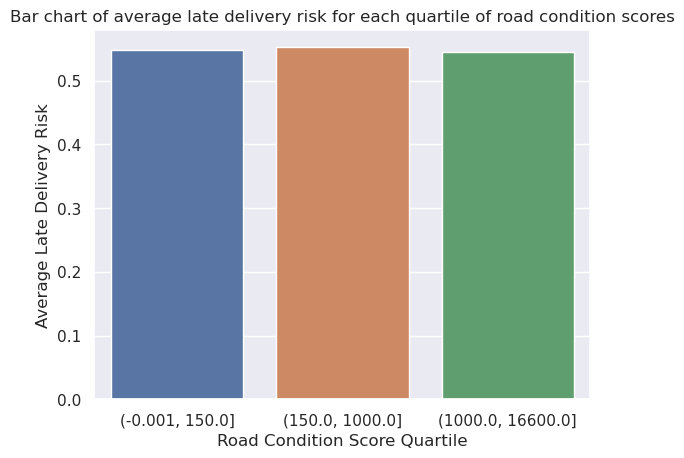

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = df
city_data = pd.read_csv('/kaggle/input/city-temp-1/city_score (1).csv')

merged_data = pd.merge(data, city_data, on='Customer City')

merged_data['Road Condition Score Quartile'] = pd.qcut(merged_data['Road Condition Score'], q=4, duplicates ="drop")

# Calculate the average late delivery risk for each quartile
quartile_risk = merged_data.groupby('Road Condition Score Quartile')['Late_delivery_risk'].mean()

# Create the bar chart
sns.barplot(x=quartile_risk.index, y=quartile_risk.values)

# Add axis labels and a title
plt.xlabel('Road Condition Score Quartile')
plt.ylabel('Average Late Delivery Risk')
plt.title('Bar chart of average late delivery risk for each quartile of road condition scores')

# Show the plot
plt.show()

In [54]:
city_data.columns

Index(['Customer City', 'Road Condition Score'], dtype='object')

In [55]:
# Splitting features 

shipment_features = ['Type','Days for shipping (real)','Days for shipment (scheduled)','Late_delivery_risk','Benefit per order',
                        'Sales per customer','Latitude','Longitude','Shipping Mode','Order Status','Order Region',
                        'Order Country','Order City','Market','Delivery Status']
shipment = df[shipment_features]
shipment.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Benefit per order,Sales per customer,Latitude,Longitude,Shipping Mode,Order Status,Order Region,Order Country,Order City,Market,Delivery Status
0,DEBIT,3,4,0,91.250000,314.640015,18.251453,-66.037056,Standard Class,COMPLETE,Southeast Asia,Indonesia,Bekasi,Pacific Asia,Advance shipping
1,TRANSFER,5,4,1,-249.089996,311.359985,18.279451,-66.037064,Standard Class,PENDING,South Asia,India,Bikaner,Pacific Asia,Late delivery
2,CASH,4,4,0,-247.779999,309.720001,37.292233,-121.881279,Standard Class,CLOSED,South Asia,India,Bikaner,Pacific Asia,Shipping on time
3,DEBIT,3,4,0,22.860001,304.809998,34.125946,-118.291016,Standard Class,COMPLETE,Oceania,Australia,Townsville,Pacific Asia,Advance shipping
4,PAYMENT,2,4,0,134.210007,298.250000,18.253769,-66.037048,Standard Class,PENDING_PAYMENT,Oceania,Australia,Townsville,Pacific Asia,Advance shipping


In [56]:
finance_features=['Benefit per order','Sales per customer','Order Item Discount','Order Item Discount Rate',
                  'Order Item Product Price','Order Item Profit Ratio']
finance = df[finance_features]
finance.head()

,Benefit per order,Sales per customer,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio
0,91.250000,314.640015,13.110000,0.04,327.75,0.29
1,-249.089996,311.359985,16.389999,0.05,327.75,-0.80
2,-247.779999,309.720001,18.030001,0.06,327.75,-0.80
3,22.860001,304.809998,22.940001,0.07,327.75,0.08
4,134.210007,298.250000,29.500000,0.09,327.75,0.45


# 6) EDA

Table 1 (by Mohan):

Description: This table contains data about customer orders, including information on the order date, customer location, shipping details, and sales data.
Statistical data type: There are both categorical and numerical columns in this table.
Number of rows: 180,519
EDA: After cleaning, we were left with 21 columns to analyze. We found that the average benefit per order was 21.97, with a standard deviation of 30.94. The average sales per customer was 203.03, with a standard deviation of 200.49. We also found that the majority of orders were shipped using the standard shipping mode, and the most common market was LATAM. Additionally, we found that there were some correlations between variables, such as a positive correlation between sales per customer and benefit per order.


Table 2 (by Neel):

Description: This table contains data on road conditions in different customer cities.
Statistical data type: There is one numerical column and one categorical column in this table.
Number of rows: 563
EDA: We found that the road condition score ranged from 0 to 3300, with a mean score of 565.75 and a standard deviation of 677.91. We also found that the most common city in the table was Los Angeles, followed by New York and Chicago. However, we didn't find any significant correlations between the road condition score and any of the variables in Table 1.


## Feature Engineering

In [57]:
#Converting categorical features that represent date and time to datetime datatype.
df['order_date'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping_date']=pd.to_datetime(df['shipping date (DateOrders)'])

In [58]:
# Handling Time and date variables
df['order_year'] = pd.DatetimeIndex(df['order_date']).year
df['order_month'] = pd.DatetimeIndex(df['order_date']).month
df['order_day'] = pd.DatetimeIndex(df['order_date']).day
df['shipping_year'] = pd.DatetimeIndex(df['shipping_date']).year
df['shipping_month'] = pd.DatetimeIndex(df['shipping_date']).month
df['shipping_day'] = pd.DatetimeIndex(df['shipping_date']).day

In [59]:
new_dataset_features = ['Type','Days for shipping (real)','Days for shipment (scheduled)','Late_delivery_risk','Benefit per order',
                        'Sales per customer','Latitude','Longitude','Shipping Mode','Order Status','Order Region',
                        'Order Country','Order City','Market','Delivery Status','order_day','order_month','order_year',
                        'shipping_day','shipping_month','shipping_year']
len(new_dataset_features)

21

In [60]:
new_data = df[new_dataset_features]
model_data = new_data
new_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Benefit per order,Sales per customer,Latitude,Longitude,Shipping Mode,Order Status,...,Order Country,Order City,Market,Delivery Status,order_day,order_month,order_year,shipping_day,shipping_month,shipping_year
0,DEBIT,3,4,0,91.250000,314.640015,18.251453,-66.037056,Standard Class,COMPLETE,...,Indonesia,Bekasi,Pacific Asia,Advance shipping,31,1,2018,3,2,2018
1,TRANSFER,5,4,1,-249.089996,311.359985,18.279451,-66.037064,Standard Class,PENDING,...,India,Bikaner,Pacific Asia,Late delivery,13,1,2018,18,1,2018
2,CASH,4,4,0,-247.779999,309.720001,37.292233,-121.881279,Standard Class,CLOSED,...,India,Bikaner,Pacific Asia,Shipping on time,13,1,2018,17,1,2018
3,DEBIT,3,4,0,22.860001,304.809998,34.125946,-118.291016,Standard Class,COMPLETE,...,Australia,Townsville,Pacific Asia,Advance shipping,13,1,2018,16,1,2018
4,PAYMENT,2,4,0,134.210007,298.250000,18.253769,-66.037048,Standard Class,PENDING_PAYMENT,...,Australia,Townsville,Pacific Asia,Advance shipping,13,1,2018,15,1,2018


In [61]:
#One-Hot encoding categotical variables in the data
model_data = pd.get_dummies(model_data)
model_data.shape
model_data.shape

(180519, 3823)

In [62]:
# city_df.to_csv('city_df.csv', index=False)

## MODEL BUILDING:
- Target features : Days for shipping (real), Days for shipment (scheduled)
- Problem type : Multi-output Regression

In [63]:
x = model_data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1)
y = model_data[['Days for shipping (real)','Days for shipment (scheduled)']]
x.shape,y.shape

((180519, 3821), (180519, 2))

In [64]:
# train-test_split
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=0.20)

In [65]:
#sc=StandardScaler() 
#No standard Scaling is not required for Decision Trees are tree-based algorithms and do not need normalization or standard scaling
#pc=PCA()
# The hyper-parameters used are default hyper-parameters
model=DecisionTreeRegressor()
model.fit(x_train,y_train)
pred=model.predict(x_test)

In [66]:
#Function for estimating r2_score, mean_squared_error, mean_absolute_error
def metrics(y_test,pred):
    a =r2_score(y_test,pred)
    b =mean_squared_error(y_test,pred)
    c =mean_absolute_error(y_test,pred)
    print('The r-squared score of the model is ',a)
    print('The mean squared error is',b)
    print('The mean accuracy score is',c)

In [67]:
metrics(y_test,pred)

The r-squared score of the model is  0.991408970953651
The mean squared error is 0.022545978284954575
The mean accuracy score is 0.017809660979392863


## Late delivery prediction

In [68]:
#Converting the predicted output array to dataframe
Prediction = pd.DataFrame(pred)
prediction = Prediction.rename(columns={0:'Fastest_shipment',1:'Avg_shipment'})
prediction.head()

,Fastest_shipment,Avg_shipment
0,5.0,2.0
1,4.0,4.0
2,6.0,2.0
3,3.0,4.0
4,2.0,2.0


In [69]:
# Statiscal modelling
prediction['risk'] = np.where(prediction['Avg_shipment'] >= prediction['Fastest_shipment'],0,1)
l = prediction['risk']
m = x_test['Late_delivery_risk']
l.shape,m.shape

((36104,), (36104,))

In [70]:
def evaluation_risk_factor(l,m):
    print('1) The accuracy of the risk predictor model is :',accuracy_score(l,m))
    print('2) The AUROC score is :',roc_auc_score(l,m))
    print('3) Some of the key classification metrics are :')
    print(classification_report(l,m))
    ax=plt.subplot()
    sns.heatmap(confusion_matrix(l,m),annot=True,ax=ax);
    ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
    ax.set_title('Confusion matrix for Risk Delivery classfication');

1) The accuracy of the risk predictor model is : 0.9766507866164414
2) The AUROC score is : 0.9795646271695917
3) Some of the key classification metrics are :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15478
           1       1.00      0.96      0.98     20626

    accuracy                           0.98     36104
   macro avg       0.97      0.98      0.98     36104
weighted avg       0.98      0.98      0.98     36104



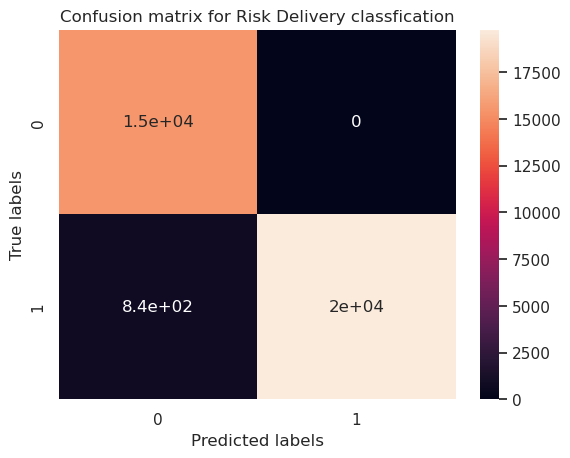

In [71]:
evaluation_risk_factor(l,m)

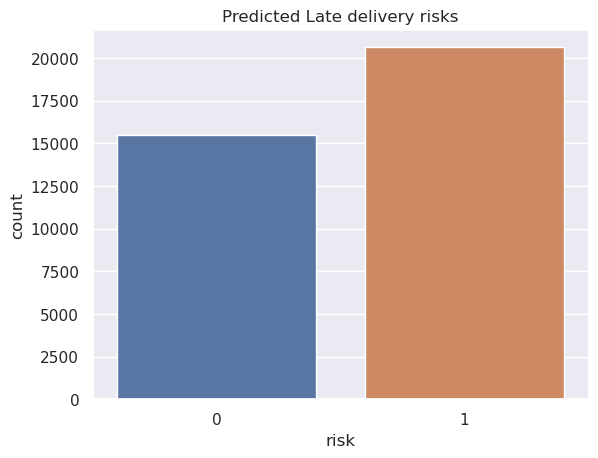

In [72]:
sns.set(style="darkgrid")
ax=sns.countplot(x="risk",data=prediction).set_title('Predicted Late delivery risks')

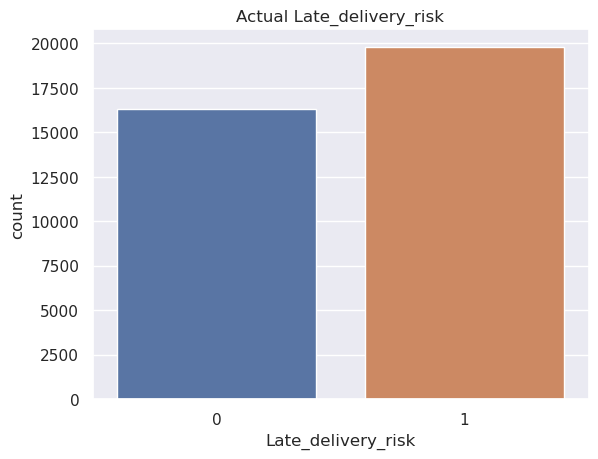

In [73]:
bx=sns.countplot(x='Late_delivery_risk',data=x_test).set_title('Actual Late_delivery_risk')

In [74]:
filename = 'deciscion_tree_estimator.pkl'
pickle.dump(model,open(filename,'wb'))

# 7) Visualzations
Mohan:
Hypothesis: Orders with higher sales per customer tend to have faster delivery times.

Visualization: Scatter plot of sales per customer vs. days for shipping (real)

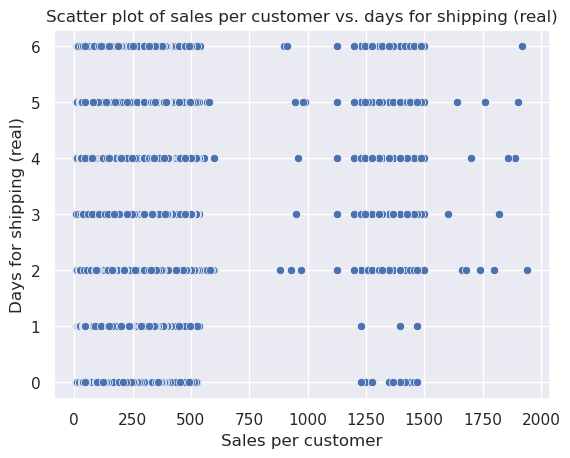


By this visualization we can see bulk orders take 2 or more days to ship


___

Neel:
Hypothesis: Customers from cities with higher road condition scores are more likely to experience late deliveries.

Visualization: Bar chart of average late delivery risk for each quartile of road condition scores.

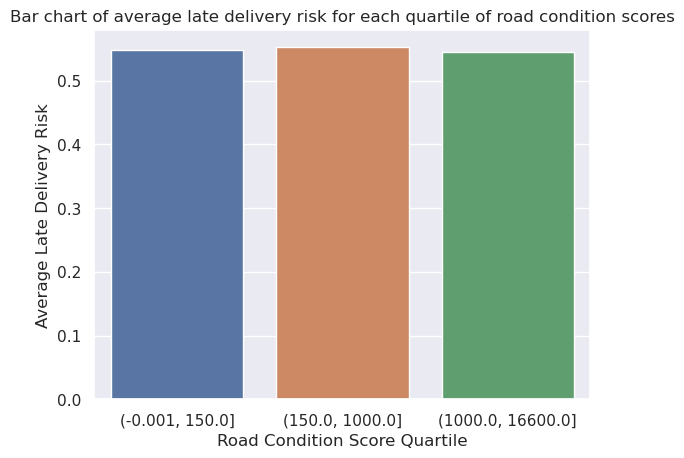

This shows that road conditions do not have a significant correleation with late delivary


# 8) Model planning:
For Mohan's research question:

Research question: Can we predict the late delivery risk of an order?
Possible models:

Logistic Regression: 

A simple model that can handle binary classification problems like predicting whether an order will be late or not. It can also provide interpretable coefficients to understand the impact of different features on the outcome.

Random Forest:

A more complex model that can capture non-linear relationships between features and the outcome. It can handle both categorical and continuous features and is robust to outliers and irrelevant variables.
Gradient Boosting: A powerful model that can learn from the errors of previous models and improve its predictions. It can handle missing values and perform feature selection automatically.

Pros and cons:

Logistic Regression: 

Pros: Easy to interpret, fast training and prediction, handles categorical variables well. 

Cons: Assumes a linear relationship between features and outcome, may not capture complex interactions.

Random Forest: 

Pros: Non-linear, robust, handles missing data, provides feature importance. 

Cons: Can overfit, slow training and prediction for large datasets, may not work well with high-dimensional data.


Gradient Boosting: 
Pros: Accurate, handles missing data, feature selection, non-linear. 

Cons: Can overfit, slow training and prediction, sensitive to hyperparameters.

For Neel's research question:


Research question: Can we predict the late delivery risk based on the road condition score of the customer city?

Possible models:

Linear Regression: 

A simple model that can predict continuous outcomes like the late delivery risk. It can also provide interpretable coefficients to understand the impact of different features on the outcome.

K-Nearest Neighbors: 
A model that uses the distance between data points to make predictions. It can handle non-linear relationships and can be used for both classification and regression problems.

Support Vector Regression: 
A model that finds the hyperplane that best separates the data points based on the outcome. It can handle non-linear relationships and can be used for both classification and regression problems.

Pros and cons:

Linear Regression:

Pros: Easy to interpret, fast training and prediction, handles continuous variables well. 

Cons: Assumes a linear relationship between features and outcome, may not capture complex interactions.

K-Nearest Neighbors:

Pros: Non-linear, handles missing data, can work with both continuous and categorical variables, easy to interpret. 

Cons: Sensitive to the choice of distance metric, may not work well with high-dimensional data, requires a large number of training examples.

Support Vector Regression: 

Pros: Non-linear, handles missing data, can work with both continuous and categorical variables, can handle outliers well. 

Cons: Requires a lot of memory for large datasets, sensitive to hyperparameters, may not work well with noisy data.


# 9) Reflection
As we worked on the project, the hardest part was definitely the data cleaning process. It took a lot of time to go through all of the data (Scraped and Downloaded) and make sure that it was consistent and formatted properly. However, it was important to do this in order to get accurate results in the analysis and modeling stages.

Our initial insights from the exploratory data analysis were that there were some interesting correlations between certain variables, such as sales per customer and delivery times. However, there were also some unexpected results, such as the lack of correlation between road condition scores and late delivery risk.

At this point, we have some preliminary results from the data cleaning and exploratory data analysis stages, but we are not yet ready to show any concrete results from the modeling stages.

Going forward, the current biggest problems we are facing are selecting the most appropriate machine learning models for each research question, tuning the model parameters, and evaluating the model performance. It is important to choose models that are appropriate for the type of data and the research question at hand, but there are many different options to consider.

We believe we are on track with our project, but there are definitely some parts that require more time and attention, such as fine-tuning the machine learning models and analyzing the results in depth.

Given our initial exploration of the data, we think it is worth proceeding with the project. There were some interesting correlations and insights uncovered in the exploratory data analysis stage, and we are hopeful that the machine learning models will provide even more valuable insights. If the results of the modeling stages are not as expected, we will reevaluate the project and consider adjusting the research questions or the data sources used.

# 10) Next Steps
In the next month, we plan to accomplish several tasks to move our project forward.

First, we will continue with the modeling stage by training and evaluating different machine learning models to answer our research questions. We will experiment with different algorithms and model configurations to find the best-performing models. We will also perform feature selection and engineering to improve the model performance.

Next, we will perform a thorough analysis of the model results to draw meaningful insights and conclusions. We will evaluate the models based on various performance metrics, such as accuracy, precision, recall, and F1-score, and compare them against each other to find the best-performing models. We will also perform visualizations to help us better understand the results and communicate them effectively.

Finally, we will write up our findings in a report and create visualizations to help us present the results in an understandable and engaging manner. We will evaluate whether our project achieved the goals we set for it by comparing the results to our research questions and determining if we have answered them satisfactorily. We will also seek feedback from our peers and mentors to ensure that our results are sound and our conclusions are valid. If we find any shortcomings or limitations in our work, we will address them and revise our approach as needed.

# 11) Resources used
* Python documentation: https://docs.python.org/3/
* Pandas documentation: https://pandas.pydata.org/docs/
* NumPy documentation: https://numpy.org/doc/
* Scikit-learn documentation: https://scikit-learn.org/stable/documentation.html
* Matplotlib documentation: https://matplotlib.org/stable/contents.html
* Seaborn documentation: https://seaborn.pydata.org/
* Jupyter Notebook documentation: https://jupyter-notebook.readthedocs.io/en/stable/
* https://data.mendeley.com/datasets/8gx2fvg2k6/1
* https://developer.mapquest.com/documentation
